In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as cls
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, AgglomerativeClustering, HDBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

#### This is a comparison of several clustering methods to see how the resulting clusters differ from that of K-Means.

### Importing the data

In [2]:
# the exact same dataset that was used for K-Means clustering
flow_data = pd.read_csv('C:/Adatok/data science/flow clustering/flow_export.csv', header=1)

In [3]:
# creating a selection of markers to work with
flow_selection = flow_data.copy()
flow_selection = flow_selection[['FJComp-APC-A', 'FJComp-PE-A']]   # to select the right channels to work with
flow_selection.rename(columns={'FJComp-APC-A':'IgD', 'FJComp-PE-A':'CD27'}, inplace=True)   # to rename channels by the markers

In [4]:
flow_selection.head()

IgD  CD27
0  417   304
1  739   506
2  709   267
3  666   355
4  236   526

### Data scaling

In [5]:
scaler = StandardScaler()
flow_mod = scaler.fit_transform(flow_selection)

In [6]:
flow_mod

array([[-0.1369767 , -0.37449753],
       [ 1.42631168,  1.04917795],
       [ 1.2806637 , -0.63526977],
       ...,
       [-1.04970407, -0.68460506],
       [ 1.31464823, -0.19830007],
       [ 1.82927111, -0.5225034 ]])

### Clustering

1. Redproducing the same K-Means clustering

In [7]:
# clustering
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=10)
kmeans.fit(flow_mod)
flow_selection['kmeans_labels'] = kmeans.labels_

In [8]:
# custom color map for the plots
color_list = ['#1B9E77', '#E7298A', '#7570B3', '#E6AB02']
custom_cmap = cls.ListedColormap(color_list)

Text(0.5, 1.0, 'K-Means')

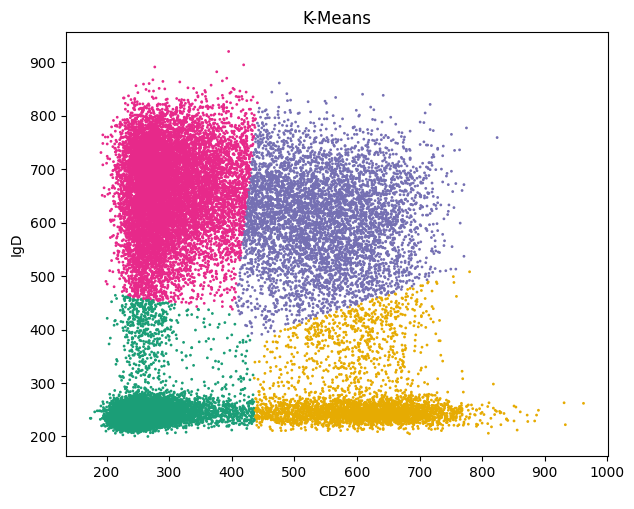

In [9]:
# visualisation
fig, ax = plt.subplots(figsize=(7,5.5))

ax.scatter(x=flow_selection['CD27'], y=flow_selection['IgD'], c=flow_selection['kmeans_labels'], s=1, cmap=custom_cmap)
ax.set_xlabel('CD27')
ax.set_ylabel('IgD')
ax.set_title(f'K-Means')

2. Mean Shift clustering

In [10]:
# estimation for bandwidth - to see what bandidth value is used by MeanShift
# the same estimation method is applied by MeanShift if no bandwidth is provided
bandwidth = estimate_bandwidth(flow_mod, n_samples=5000)

In [11]:
bandwidth

0.998601199724322

In [12]:
# testing different bandwidths for Mean Shift
bw_list = [0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3]

for i in bw_list:
    ms = MeanShift(bandwidth=i, bin_seeding=True)
    ms.fit(flow_mod)
    flow_selection[f'MS_bw{i}'] = ms.labels_

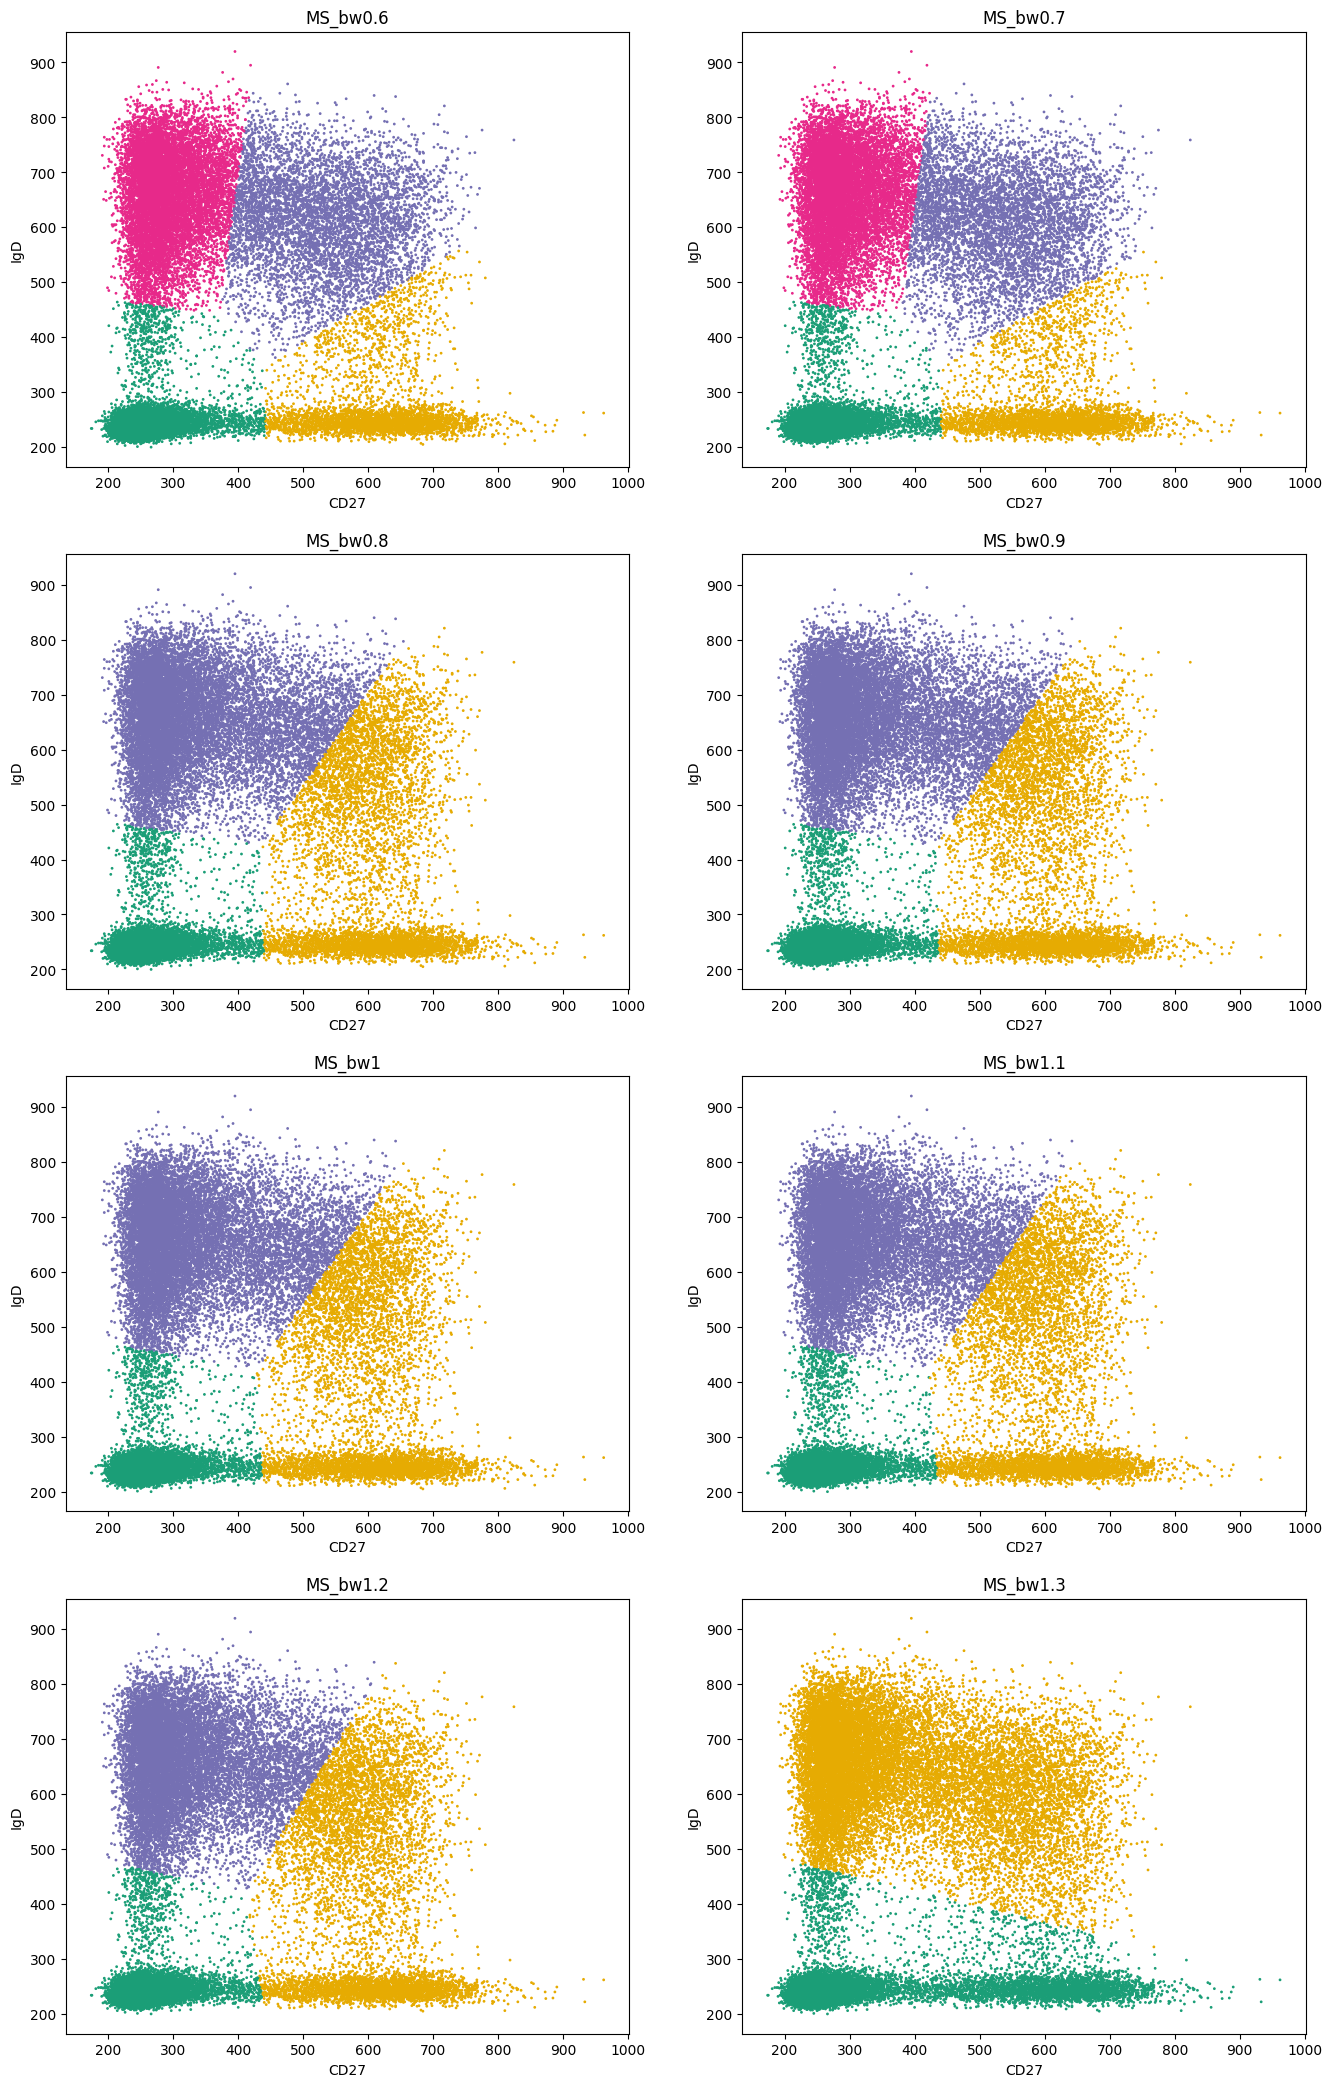

In [13]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(16,26))

for i, ax in enumerate(fig.axes):
    ax.scatter(x=flow_selection['CD27'], y=flow_selection['IgD'], c=flow_selection[f'MS_bw{bw_list[i]}'], s=1, cmap=custom_cmap)
    ax.set_xlabel('CD27')
    ax.set_ylabel('IgD')
    ax.set_title(f'MS_bw{bw_list[i]}')

3. Agglomerative clustering

In [14]:
# testing different linkage methods for Agglomerative clustering
linkage_list = ['ward', 'complete', 'average', 'single']

for i in linkage_list:
    agg = AgglomerativeClustering(n_clusters=4, linkage=i)
    agg.fit(flow_mod)
    flow_selection[f'Agg_{i}'] = agg.labels_

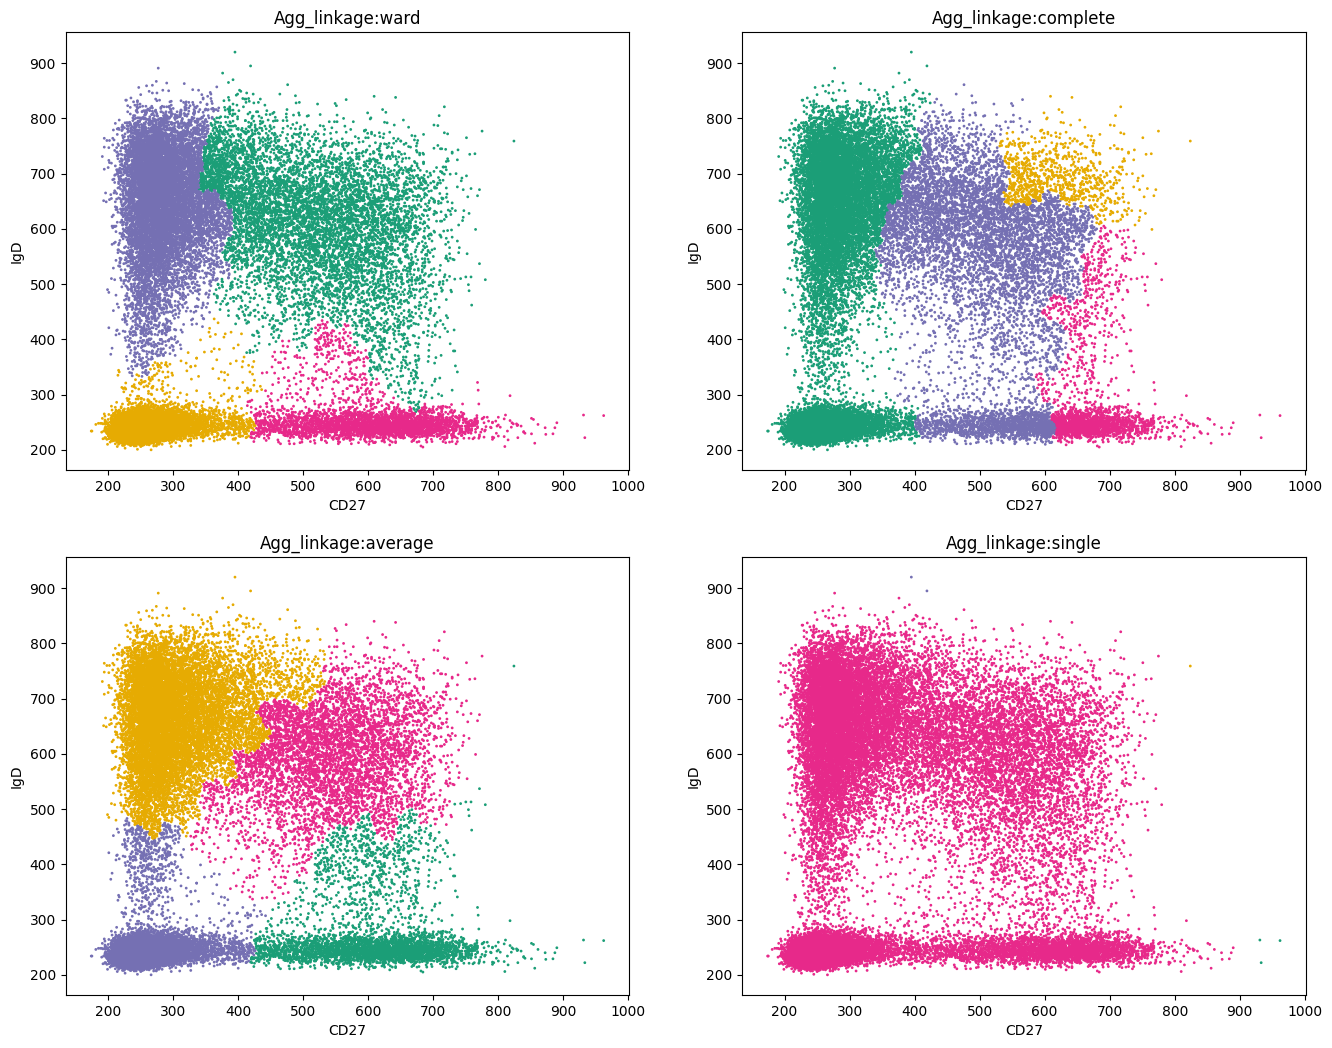

In [15]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,12.5))

for i, ax in enumerate(fig.axes):
    ax.scatter(x=flow_selection['CD27'], y=flow_selection['IgD'], c=flow_selection[f'Agg_{linkage_list[i]}'], s=1, cmap=custom_cmap)
    ax.set_xlabel('CD27')
    ax.set_ylabel('IgD')
    ax.set_title(f'Agg_linkage:{linkage_list[i]}')

4. Gaussian Mixture Model

In [16]:
# testing different covariance types for GMM
covar_list = ['full', 'tied', 'diag', 'spherical']

for i in covar_list:
    gmm = GaussianMixture(n_components=4, covariance_type=i)
    gmm.fit(flow_mod)
    flow_selection[f'GMM_covar:{i}'] = gmm.predict(flow_mod)

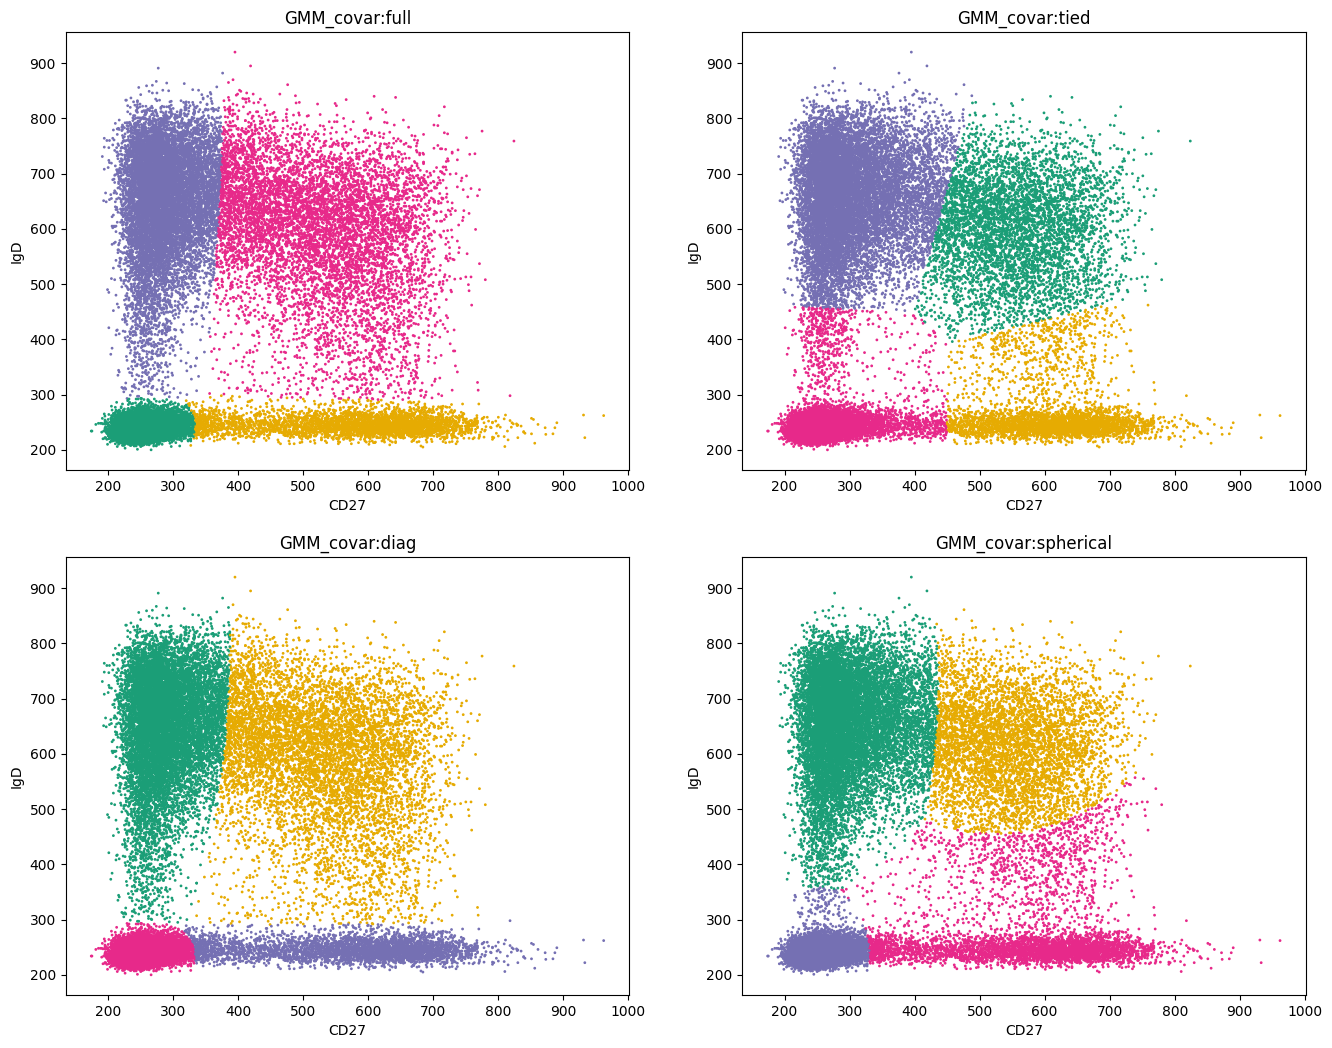

In [17]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,12.5))

for i, ax in enumerate(fig.axes):
    ax.scatter(x=flow_selection['CD27'], y=flow_selection['IgD'], c=flow_selection[f'GMM_covar:{covar_list[i]}'], s=1, cmap=custom_cmap)
    ax.set_xlabel('CD27')
    ax.set_ylabel('IgD')
    ax.set_title(f'GMM_covar:{covar_list[i]}')

5. HDBSCAN clustering

In [18]:
# testing different minimum cluster sizes for HDBSCAN
minClus_list = [20, 40, 60, 80, 100, 200]

for i in minClus_list:
    hdb = HDBSCAN(min_cluster_size=i)
    hdb.fit(flow_mod)
    flow_selection[f'HDB_minClus{i}'] = hdb.labels_

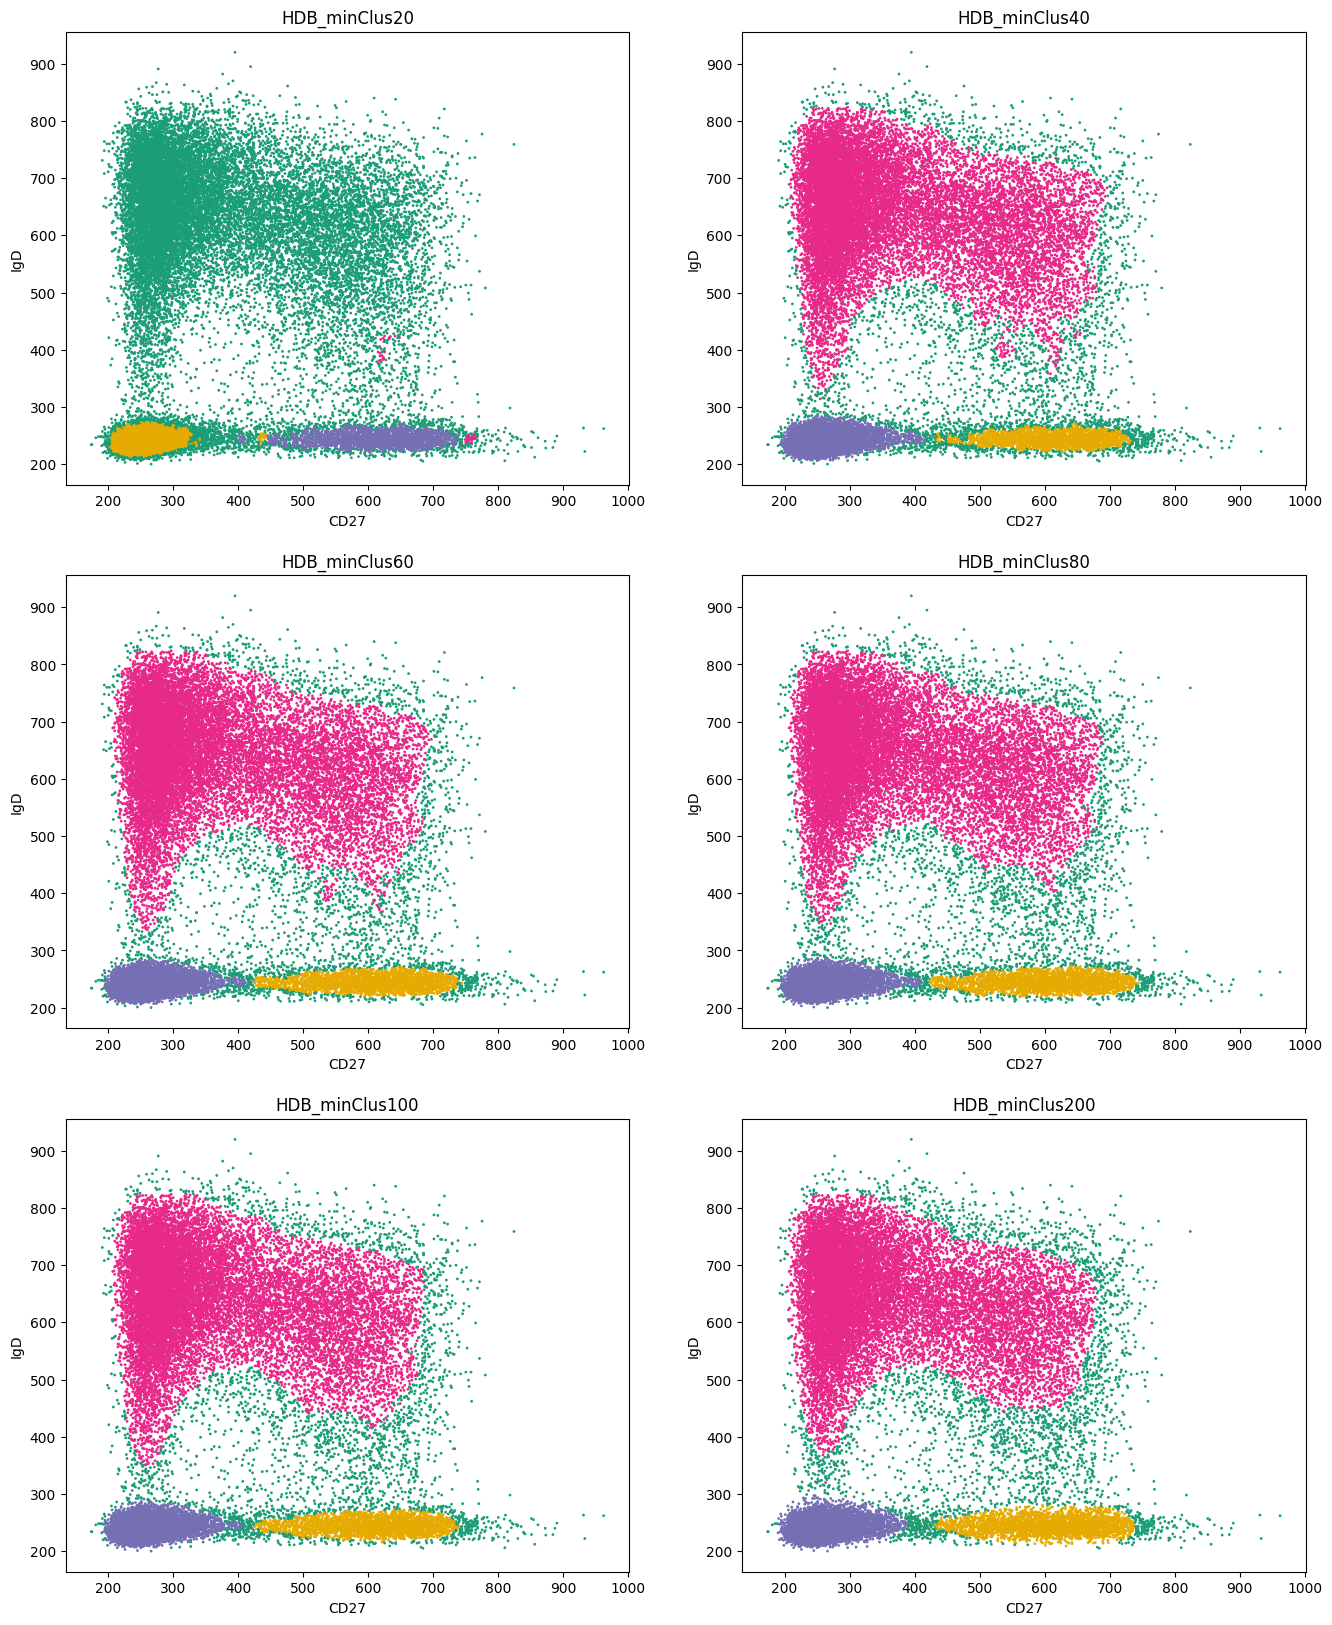

In [19]:
# in all plots, green dots represent the data points that were labelled with -1
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(16,20))

for i, ax in enumerate(fig.axes):
    ax.scatter(x=flow_selection['CD27'], y=flow_selection['IgD'], c=flow_selection[f'HDB_minClus{minClus_list[i]}'], s=1, cmap=custom_cmap)
    ax.set_xlabel('CD27')
    ax.set_ylabel('IgD')
    ax.set_title(f'HDB_minClus{minClus_list[i]}')

### Visualisation of the comparison

In [20]:
# creating another custom color map specifically for HDBSCAN
color_list2 = ['#000000', '#1B9E77', '#E7298A', '#7570B3']
custom_cmap2 = cls.ListedColormap(color_list2)

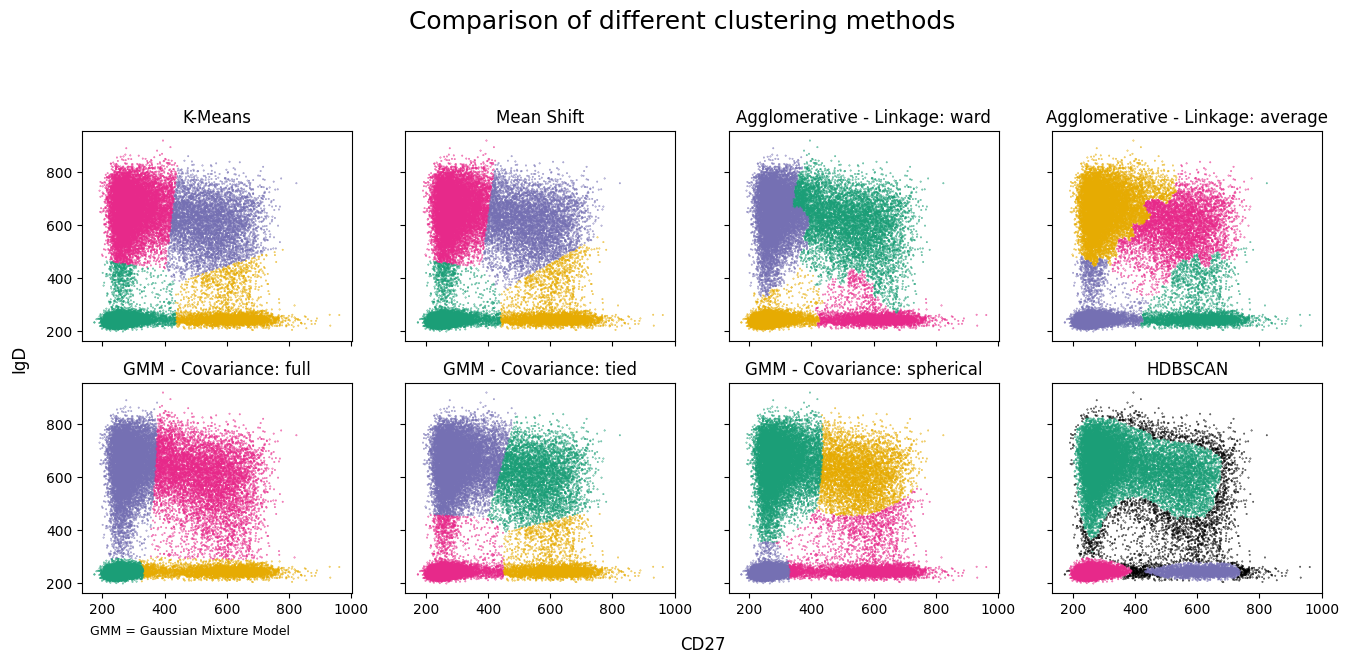

In [21]:
# the final plot for visual comparison
fig, ax = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, figsize=(16,6))
fig.text(0.5, 1.05, 'Comparison of different clustering methods', ha='center', size=18)
fig.text(0.513, 0.015, 'CD27', ha='center', size=12)
fig.text(0.08, 0.5, 'IgD', va='center', rotation='vertical', size=12)
fig.text(0.13, 0.04, 'GMM = Gaussian Mixture Model', size=9)

ax[0][0].scatter(x=flow_selection['CD27'], y=flow_selection['IgD'], c=flow_selection['kmeans_labels'], s=.1, cmap=custom_cmap)
ax[0][0].set_title('K-Means')

ax[0][1].scatter(x=flow_selection['CD27'], y=flow_selection['IgD'], c=flow_selection['MS_bw0.7'], s=.1, cmap=custom_cmap)
ax[0][1].set_title('Mean Shift')

ax[0][2].scatter(x=flow_selection['CD27'], y=flow_selection['IgD'], c=flow_selection['Agg_ward'], s=.1, cmap=custom_cmap)
ax[0][2].set_title('Agglomerative - Linkage: ward')

ax[0][3].scatter(x=flow_selection['CD27'], y=flow_selection['IgD'], c=flow_selection['Agg_average'], s=.1, cmap=custom_cmap)
ax[0][3].set_title('Agglomerative - Linkage: average')

ax[1][0].scatter(x=flow_selection['CD27'], y=flow_selection['IgD'], c=flow_selection['GMM_covar:full'], s=.1, cmap=custom_cmap)
ax[1][0].set_title('GMM - Covariance: full')

ax[1][1].scatter(x=flow_selection['CD27'], y=flow_selection['IgD'], c=flow_selection['GMM_covar:tied'], s=.1, cmap=custom_cmap)
ax[1][1].set_title('GMM - Covariance: tied')

ax[1][2].scatter(x=flow_selection['CD27'], y=flow_selection['IgD'], c=flow_selection['GMM_covar:spherical'], s=.1, cmap=custom_cmap)
ax[1][2].set_title('GMM - Covariance: spherical')

ax[1][3].scatter(x=flow_selection['CD27'], y=flow_selection['IgD'], c=flow_selection['HDB_minClus200'], s=.1, cmap=custom_cmap2)
ax[1][3].set_title('HDBSCAN')

plt.savefig('comparison_clust.jpg', bbox_inches='tight', dpi=200)

HDBSCAN did not separate IgD<sup>+</sup> cells into two populations along the marker CD27. These cells remained in the same cluster even with notably higher number of clusters.

<br>

### Evaluation of clustering results

In [22]:
# lists with the above selected clustering methods
cTypes = ['kmeans_labels', 'MS_bw0.7', 'Agg_ward', 'Agg_average', 'GMM_covar:full', 'GMM_covar:tied', 'GMM_covar:spherical', 'HDB_minClus200']
cNames = ['K-means', 'Mean shift', 'Agglomerative (ward)', 'Agglomerative (average)', 'GMM (full)', 'GMM (tied)', 'GMM (spherical)', 'HDBSCAN']

In [23]:
# calculate metrics
sScore_list = []
dbScore_list = []
chScore_list = []

for clmn in cTypes:
    sScore = silhouette_score(flow_mod, flow_selection[clmn])
    sScore_list.append(round(sScore, 3))
    dbScore = davies_bouldin_score(flow_mod, flow_selection[clmn])
    dbScore_list.append(round(dbScore, 3))
    chScore = calinski_harabasz_score(flow_mod, flow_selection[clmn])
    chScore_list.append(round(chScore, 3))

In [24]:
# create series
namesSeries = pd.Series(cNames)
sSeries = pd.Series(sScore_list)
dbSeries = pd.Series(dbScore_list)
chSeries = pd.Series(chScore_list)

# create dictionary
dict_temp = {'clustering_method': namesSeries, 
             'silhouette_score': sSeries, 
             'davies_bouldin_score': dbSeries, 
             'calinski_harabasz_score': chSeries}

# create dataframe
cluster_eval = pd.DataFrame(dict_temp)

In [25]:
cluster_eval

clustering_method  silhouette_score  davies_bouldin_score  \
0                  K-means             0.655                 0.583   
1               Mean shift             0.649                 0.591   
2     Agglomerative (ward)             0.609                 0.641   
3  Agglomerative (average)             0.640                 0.623   
4               GMM (full)             0.596                 0.701   
5               GMM (tied)             0.655                 0.577   
6          GMM (spherical)             0.625                 0.665   
7                  HDBSCAN             0.524                 1.257   

   calinski_harabasz_score  
0                83607.523  
1                82511.014  
2                65855.979  
3                76416.079  
4                58400.528  
5                82580.404  
6                68294.380  
7                27077.103

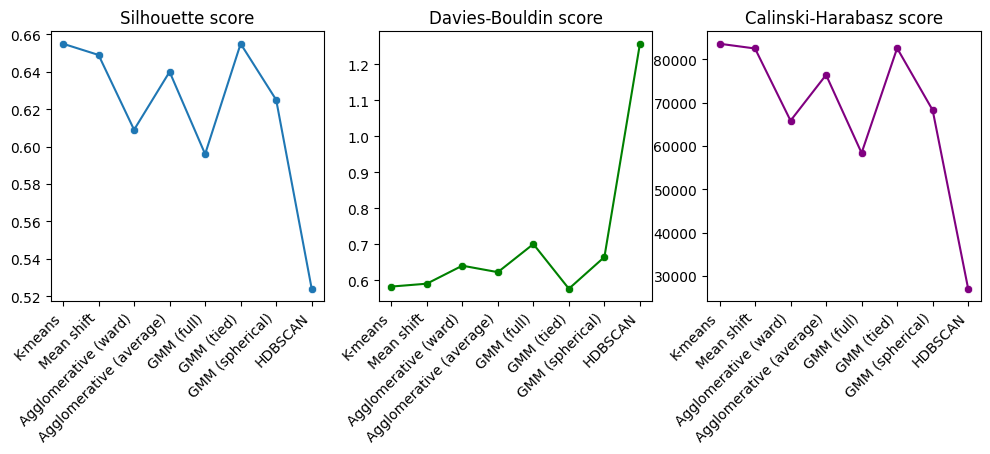

In [26]:
# visualize the metrics
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(12,3.5))

sns.lineplot(data=cluster_eval, x='clustering_method', y='silhouette_score', ax=ax[0])
sns.scatterplot(data=cluster_eval, x='clustering_method', y='silhouette_score', ax=ax[0])
ax[0].set_title('Silhouette score')
ax[0].set_xlabel('')
ax[0].set_xticks(ax[0].get_xticks())
ax[0].set_xticklabels(cluster_eval['clustering_method'], rotation=45, ha='right')
ax[0].set_ylabel('')

sns.lineplot(data=cluster_eval, x='clustering_method', y='davies_bouldin_score', color='g', ax=ax[1])
sns.scatterplot(data=cluster_eval, x='clustering_method', y='davies_bouldin_score', color='g', ax=ax[1])
ax[1].set_title('Davies-Bouldin score')
ax[1].set_xlabel('')
ax[1].set_xticks(ax[1].get_xticks())
ax[1].set_xticklabels(cluster_eval['clustering_method'], rotation=45, ha='right')
ax[1].set_ylabel('')

sns.lineplot(data=cluster_eval, x='clustering_method', y='calinski_harabasz_score', color='purple', ax=ax[2])
sns.scatterplot(data=cluster_eval, x='clustering_method', y='calinski_harabasz_score', color='purple', ax=ax[2])
ax[2].set_title('Calinski-Harabasz score')
ax[2].set_xlabel('')
ax[2].set_xticks(ax[2].get_xticks())
ax[2].set_xticklabels(cluster_eval['clustering_method'], rotation=45, ha='right')
ax[2].set_ylabel('')

plt.savefig('clust_metrics.jpg', bbox_inches='tight', dpi=200)